CS 4375 - Final Project

**Author**: Alec Ibarra\
**Date**: 2024-10-26

In [1]:
# Install dependencies
%pip install --upgrade pip
%pip install ipykernel
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install tensorflow[and-cuda]
%pip install keras-tuner
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import dependencies
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


2024-10-30 15:00:47.485410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 15:00:48.727150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730318449.152971    9357 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730318449.268768    9357 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 15:00:50.341054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Tensorflow version
print(f"Tensorflow: v{tf.__version__}")

# Check GPU availability
print(f"GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print(tf.config.list_physical_devices('GPU'))

Tensorflow: v2.18.0
GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape data to add a channel dimension, normalize pixel values
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Display some info and stats about the dataset
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Number of classes: {y_train.shape[1]}')

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Number of classes: 10


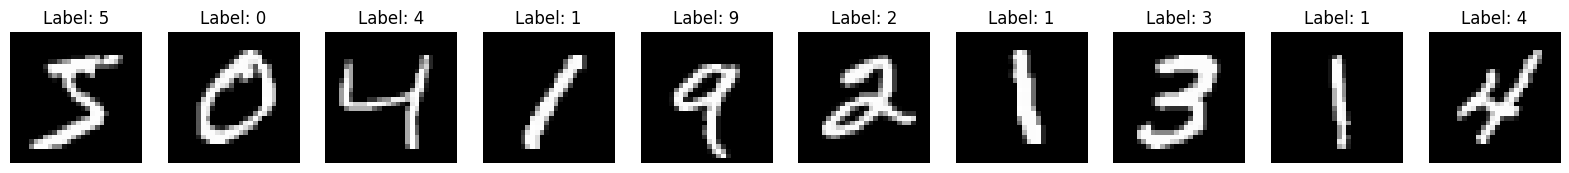

In [5]:
# Plot some data samples
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {np.argmax(y_train[i])}')
    ax.axis('off')

In [6]:
batch_size = 96

# Define the CNN model for tuning
def create_model(hp):
    # Define a wider hyperparameter range for more comprehensive search
    conv1 = hp.Int('conv1', min_value=32, max_value=256, step=32)
    conv2 = hp.Int('conv2', min_value=32, max_value=256, step=32)
    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    
    # Build the model architecture
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(conv1, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(conv2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    
    # Compile the model with the chosen learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize the tuner
tuner = Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=2,
    hyperband_iterations=5,
    directory='hyperband',
    project_name=f'{batch_size}_cnn_mnist_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

I0000 00:00:1730318468.136382    9357 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9702 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Reloading Tuner from hyperband/96_cnn_mnist_tuning/tuner0.json


In [7]:
# Start the search for the best hyperparameters
tuner.search(
    X_train,
    y_train,
    epochs=30,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping]
)

In [8]:
# Train the best model
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_trial.hyperparameters)
history = best_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=batch_size,
).history

# Generate predictions for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/30


I0000 00:00:1730318471.105598    9650 service.cc:148] XLA service 0x7fcafc009ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730318471.105731    9650 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-10-30 15:01:11.196247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730318471.367983    9650 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-10-30 15:01:12.583051: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[96,128,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,256,13,13]{3,2,1,0}, f32[128,256,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"ac

 23/625 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3144 - loss: 1.9926

I0000 00:00:1730318473.839438    9650 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8334 - loss: 0.5222

2024-10-30 15:01:17.962815: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[96,128,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,256,13,13]{3,2,1,0}, f32[128,256,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-30 15:01:18.418656: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[16,128,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,256,13,13]{3,2,1,0}, f32[128,256,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_confi

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8347 - loss: 0.5183 - val_accuracy: 0.9859 - val_loss: 0.0451
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9752 - loss: 0.0848 - val_accuracy: 0.9869 - val_loss: 0.0382
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9818 - loss: 0.0611 - val_accuracy: 0.9901 - val_loss: 0.0298
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9867 - loss: 0.0465 - val_accuracy: 0.9904 - val_loss: 0.0254
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9882 - loss: 0.0409 - val_accuracy: 0.9923 - val_loss: 0.0222
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9896 - loss: 0.0323 - val_accuracy: 0.9927 - val_loss: 0.0224
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9916 - loss: 0.0260 - val_accuracy: 0.9938 - val_loss: 0.0182
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9919 - loss: 0.0263 - val_accuracy: 0.9945 - val_

2024-10-30 15:03:18.739686: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,128,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,13,13]{3,2,1,0}, f32[128,256,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


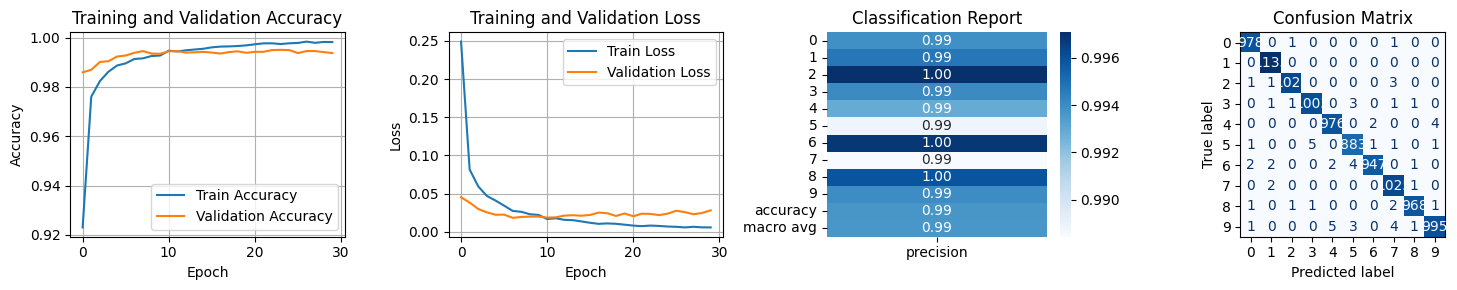

In [9]:
# Combined figure for accuracy, loss, and confusion matrix
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

# Best model's accuracy
axes[0].plot(history['accuracy'], label='Train Accuracy')
axes[0].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].set_title('Training and Validation Accuracy')
axes[0].grid(True)

# Best model's loss
axes[1].plot(history['loss'], label='Train Loss')
axes[1].plot(history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].set_title('Training and Validation Loss')
axes[1].grid(True)

# Best model's classification report
report = classification_report(y_true, y_pred_classes, output_dict=True)
df = pd.DataFrame(report).transpose()
sns.heatmap(df.iloc[:-1, :-3], annot=True, fmt=".2f", cmap='Blues', ax=axes[2])
axes[2].set_title('Classification Report')
axes[2].grid(False)

# Confusion matrix for the best model predictions
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues, ax=axes[3], colorbar=False)
axes[3].set_title('Confusion Matrix')
axes[3].grid(False)

# Adjust layout and display the figure
plt.tight_layout()

# Save the figure
os.makedirs('results', exist_ok=True)
plt.savefig(f'results/{batch_size}-best.png')

# Display the figure
plt.show()

In [10]:
# Extract all results from tuner
trials = tuner.oracle.get_best_trials(num_trials=9999)

# Create a DataFrame with trial IDs, hyperparameters, and scores
results_df = pd.DataFrame({
    'trial_id': [trial.trial_id for trial in trials],
    'mean_val_accuracy': [trial.score for trial in trials],
    'conv1': [trial.hyperparameters.values['conv1'] for trial in trials],
    'conv2': [trial.hyperparameters.values['conv2'] for trial in trials],
    'dense_units': [trial.hyperparameters.values['dense_units'] for trial in trials],
    'dropout_rate': [trial.hyperparameters.values['dropout_rate'] for trial in trials],
    'learning_rate': [trial.hyperparameters.values['learning_rate'] for trial in trials],
    'batch_size': batch_size,
})

# Save the results to a CSV file
os.makedirs('results', exist_ok=True)
results_df.to_csv(f'results/{batch_size}-all.csv', index=True)
results_df.head()

,trial_id,mean_val_accuracy,conv1,conv2,dense_units,dropout_rate,learning_rate,batch_size
0,0127,0.994083,256,128,224,0.6,0.000591,96
1,0130,0.993583,256,128,224,0.6,0.000591,96
2,0407,0.993333,160,192,256,0.5,0.000867,96
3,0245,0.993167,96,256,192,0.7,0.000429,96
4,0175,0.993167,64,96,160,0.6,0.001588,96
